In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
# from vizdoom import *
from doom_src import utilities
from collections import defaultdict
from collections import deque
import random
import matplotlib.pyplot as plt
import tqdm

In [3]:
def eGreedyActionSelection(q_curr, eps):
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        index of action
    '''
    r = np.random.random()
    if r < eps:
        #eps of the time return a random index of the vector q_curr
        return np.random.randint(0,len(q_curr))
    else:
        #1-eps of the time return an index of the max element of q (ties broken randomly)
        max_index = [0]
        for i in range(0,len(q_curr)):
            if q_curr[i] > q_curr[max_index[0]]:
                max_index = [i]
            elif q_curr[i] == q_curr[max_index[0]]:
                max_index.append(i)
        return random.choice(max_index)    
    

In [4]:
def sarsa(game, actions, num_episodes, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=100):
    '''
    Sarsa algorithm.
    
    Args:
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - alpha: The stepsize
        - start_eps: The initial epsilon value for e-greedy action selection
        - final_eps: The final epsilon value for the e-greedy action selection
        - annealing_steps: The number of steps to anneal epsilon over
        - max_episode_steps: The maximum number of steps an episode can take
        
    Returns: (Q_func, episode_rewards, episode_lengths)
        - Q: Dictonary mapping state -> action values
        - episode_rewards: Numpy array containing the reward of each episode during training
        - episode_lengths: Numpy array containing the length of each episode during training
    '''
    Q = defaultdict(lambda: np.zeros(len(actions)))
    episode_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    
    exploration = utilities.LinearSchedule(annealing_steps, final_eps, start_eps)
    
    for i in range(num_episodes):
        #initialize queue for stacked_frames
        stacked_frames  =  deque([np.zeros((config['frame_size'],
                config['frame_size']),
                dtype=np.int) for i in range(config['stack_size'])], maxlen=4
        ) 
        #fill the queue (initialize S)
        frame = game.get_state().screen_buffer
        state = utilities.stack_frames(
              stacked_frames, frame, True, config['stack_size'], config['frame_size']
        )
        #Choose A greedily
        action = eGreedyActionSelection(Q[hash(state.tostring())], exploration.value(i))
        
        for t in range(max_episode_steps):
            #Take action A, observe R, done, 
            reward = game.make_action(actions[action], config['skip_rate'])
            # if episode is done, then the next state will be all black, not just the 4th frame
            # This is so the done state is unique.
            done = game.is_episode_finished()
            if not done:
                next_frame = game.get_state().screen_buffer
            else:
                next_frame = np.zeros(frame.shape, dtype=np.int)
            #observe S'
            next_state = utilities.stack_frames(stacked_frames, next_frame,
                        done, config['frame_size'], config['frame_size']
            )
            next_action = eGreedyActionSelection(Q[hash(next_state.tostring())],exploration.value(i) )
            episode_rewards[i] += reward
            episode_lengths[i] += 1

            Q[hash(state.tostring())][action] += alpha*(reward + gamma * Q[hash(next_state.tostring())][next_action] - Q[hash(state.tostring())][action])
            if done:
                game.new_episode()
                break
            state = next_state
            action = next_action 
    
    return Q, episode_rewards, episode_lengths

In [5]:
config = utilities.get_config("configs/config.json")
# utilities.test_environment(config)



config
game, actions = utilities.create_environment(config) 
num_episodes = 120000

# Q, episode_rewards, episode_lengths = sarsa(game, actions, num_episodes, .9, 
#                 config['learning_rate'], config['annealing_start'],
#                 config['annealing_stop'], config['annealing_steps'], 200                                         
# 

Q, episode_rewards, episode_lengths = sarsa(game, 
    actions, num_episodes, 1, 0.01, 1, 0, 100000, 300                                       
)

game.close()


<function matplotlib.pyplot.show(*args, **kw)>

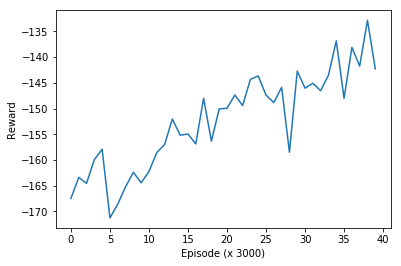

In [9]:
smooth_window = 3000
plotting_avg = list()  
sum_episodes = 0 
for i in range(1, num_episodes+1):
    sum_episodes += episode_rewards[i-1]/smooth_window
    if i%smooth_window ==0:
        plotting_avg.append(sum_episodes)
        sum_episodes = 0  

plt.plot(plotting_avg)
plt.xlabel('Episode (x 3000)')
plt.ylabel('Reward')
# plt.title('Sarsa learning curve')
plt.show


